# Comparative Analysis of Machine Learning Models
In this Jupyter notebook, undertaking an evaluation of various machine learning models to predict corporate credit ratings utilizing a range of popular algorithms including neural networks, random forests, Support Vector Classifier (SVC), Gradient Boosting Machine (GBM), and XGBoost. By examining these models side by side, aiming to gain insights into their performance, strengths, and weaknesses. Seeking to identify the most suitable model for this dataset and predicting the binary credit rating. 

In [1]:
# Importing Dependencies 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline  
import sqlite3
from pathlib import Path
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
import keras_tuner as kt
from joblib import dump, load
import graphviz
import xgboost as xgb


Utilizing database tables to instantiate dataframes, with a focus on testing various dataset features across different tables, including those containing categorical data. Ultimately, opted against utilizing tables with categorical data due to challenges in synchronizing the data with API endpoints, rendering it less feasible for integration.

In [2]:
# Connect to DB and import data into a pandas dataframe
connection = sqlite3.connect('../data/db.sqlite')
ratings = pd.read_sql_query("SELECT * FROM ratings", connection)
clean = pd.read_sql_query("SELECT * FROM clean", connection)
dummies = pd.read_sql_query("SELECT * FROM dummies", connection)
clean2 = pd.read_sql_query("SELECT * FROM clean2", connection)
dummies2 = pd.read_sql_query("SELECT * FROM dummies2", connection)

connection.close()

## Neural Network Machine Learning
This code defines functions for training and evaluating a deep learning model to predict Binary Credit Ratings. The processing function includes options to oversample and undersample to address class imbalance in the data. The functions allow for specifying the number of layers, neurons, and EPOCHs. The model generates a confusion matrix and classification report. 

In [3]:
# Deep Learning Model Function
def preprocess_data(df, sampling=None):
    X = df.drop(['Binary Rating'], axis=1)
    y = df['Binary Rating']
    
    if sampling == 'over':
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_resampled, y_resampled = oversample.fit_resample(X, y)
        print(y.describe())
    elif sampling == 'under':
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_resampled, y_resampled = undersample.fit_resample(X, y)
        print(y.describe())
    elif sampling == 'smote':
        smt = SMOTE()
        X_resampled, y_resampled = smt.fit_resample(X, y)
        print(y.describe())
    else:
        X_resampled, y_resampled = X, y
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42)
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

def build_model(X_train_scaled, hidden_layers):
    number_input_features = len(X_train_scaled[0])
    nn = tf.keras.models.Sequential()
    
    # Add input layer
    nn.add(tf.keras.layers.Dense(units=hidden_layers[0][0], input_dim=number_input_features, activation=hidden_layers[0][1]))
    
    # Add middle hidden layers
    for i in range(1, len(hidden_layers)):
        nn.add(tf.keras.layers.Dense(units=hidden_layers[i][0], activation=hidden_layers[i][1]))
    
    # Add output layer
    nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn

def train_model(nn, X_train_scaled, y_train, EPOCHS, model):
    mini_path = f'../models/deeplearning/checkpoints/model{model}'
    checkpoint_filepath = mini_path + 'weights.epoch_{epoch:02d}.weights.h5'  # Adjusted filepath
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_freq=5,
        verbose=True)
    fit_model = nn.fit(X_train_scaled, y_train, epochs=EPOCHS, callbacks=[model_checkpoint_callback])
    return fit_model

def evaluate_model(nn, X_test_scaled, y_test, model):
    model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
    print(f"Model {model}-- Loss: {model_loss}, Accuracy: {model_accuracy}")
    
    predictions = nn.predict(X_test_scaled)
    predictions = np.argmax(predictions, axis=1)
    
    cm = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    
    return cm

def plot_confusion_matrix(cm, model):
    sns.set()
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig(f'../img/models/deeplearning/model{model}_confusion_matrix.png')
    plt.show()

def save_model_plot(nn, model):
    plot_model(nn, to_file=f'../img/models/deeplearning/model{model}_plot.png', show_shapes=True, show_layer_names=True)

def save_model(nn, model):
    nn.save(f'../models/deeplearning/model{model}/model.h5')

def pipeline(df, hidden_layers, EPOCHS, model, sampling=None):
    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(df, sampling)
    nn = build_model(X_train_scaled, hidden_layers)
    trained_model = train_model(nn, X_train_scaled, y_train, EPOCHS, model)
    cm = evaluate_model(nn, X_test_scaled, y_test, model)
    plot_confusion_matrix(cm, model)
    save_model_plot(nn, model)
    save_model(nn, model)


## Neural Network Training Process

In model the `pipeline` function launches other functions to train the neural network model Below is an explanation of how the `pipeline` function call works:


### 1. Defining Neural Network Architecture

The `pipeline` function takes the following parameters:

- `df`: Defines which DataFrame to train the model. 
- `hidden_layers`: A list of tuples specifying the architecture of the neural network. Each tuple contains the number of neurons and the activation function for a hidden layer.
- `EPOCHS`: The number of training epochs.
- `model`: An identifier for the model being trained.
- `sampling`: An optional parameter for data sampling technique (e.g., 'over', 'under', 'smote').

### 2. Calling the `pipeline` Function

To train a neural network model, we call the `pipeline` function with the desired parameters:

```python
pipeline(df=dummies2, #dummies is one example where get dummies was Employed for categorical data preprocessing
         hidden_layers=[(64, 'relu'), (1, 'sigmoid')],  # Example with no middle layers
         EPOCHS=75,
         model=1,
         sampling='none')


### Testing the Neural Network Model with different parameters 

#### Testing the Models
- Evaluated the initial model design on multiple dataframes, all based on the same original data.
- Initial dataframes ("clean" and "dummies") involved feature engineering and had better classification reports but suffered from overfitting due to features like "rating agency."
- Subsequent dataframes ("clean2" and "dummies2") addressed overfitting by removing these features, while also making it easier to intergrate with the API data.
 

Epoch 1/75


/opt/anaconda3/envs/dev/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/183 ━━━━━━━━━━━━━━━━━━━━ 1:46 588ms/step - accuracy: 0.3125 - loss: 0.9127
Epoch 1: saving model to ../models/deeplearning/checkpoints/model1weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model1weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model1weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model1weights.epoch_01.weights.h5
 22/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3513 - loss: 0.8794    
Epoch 1: saving model to ../models/deeplearning/checkpoints/model1weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model1weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model1weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model1weights.epoch_01.weights.h5
 40/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3547 - loss: 0.8738
Epoch 1: 

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


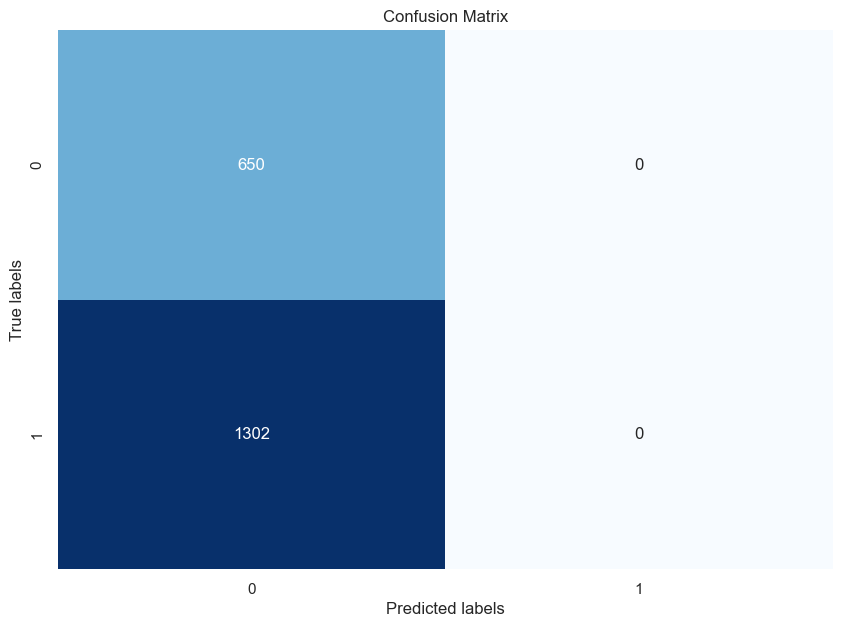

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [4]:
# Model Testing
pipeline(df=clean2,
         hidden_layers=[(4, 'relu'), (2, 'relu'), (1, 'relu'), (1, 'sigmoid')], 
         EPOCHS=75,
         model=1,
         sampling='none')

The low percision indicate class imbalance as shown below. The next attempts will utilize oversampling and undersampling to compare results.  

In [5]:
# Class Imbalance in the clean2 dataframe
clean2['Binary Rating'].value_counts()

Binary Rating
1    5099
0    2706
Name: count, dtype: int64

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64


/opt/anaconda3/envs/dev/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/75
  1/239 ━━━━━━━━━━━━━━━━━━━━ 2:12 555ms/step - accuracy: 0.4062 - loss: 0.7396
Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weights.epoch_01.weights.h5
 27/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4981 - loss: 0.7061    
Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model2weight

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


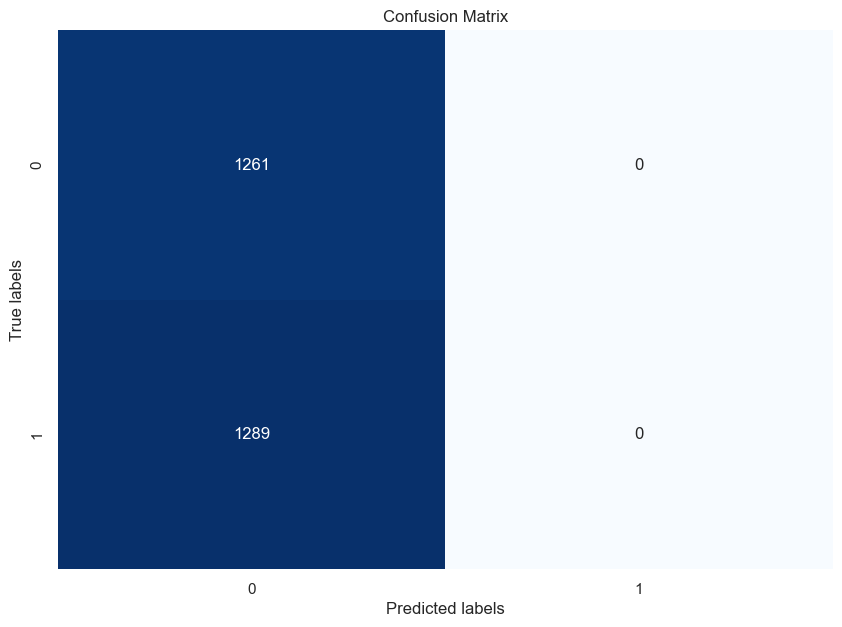

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [6]:
# Model Testing with over sampling
pipeline(df=clean2,
         hidden_layers=[(4, 'relu'), (2, 'relu'), (1, 'relu'), (1, 'sigmoid')], 
         EPOCHS=75,
         model=2,
         sampling='over')

This model still ignoring the positive class. Testing with under sampling. 

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Epoch 1/75


/opt/anaconda3/envs/dev/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:24 668ms/step - accuracy: 0.4688 - loss: 0.7487
Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.weights.h5
 25/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4778 - loss: 0.7626    
Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model3weights.epoch_01.

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


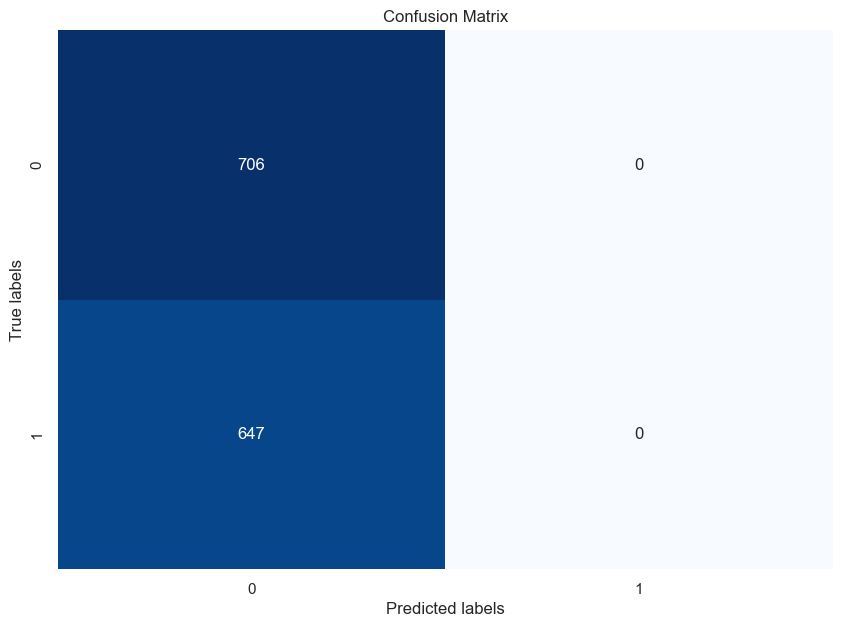

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [7]:
# Model Testing with over sampling
pipeline(df=clean2,
         hidden_layers=[(4, 'relu'), (2, 'relu'), (1, 'relu'), (1, 'sigmoid')], 
         EPOCHS=75,
         model=3,
         sampling='under')

As expected, undersampling is not helping the issue with positive precision and recall. Attempting same setup with SMOTE for oversampling

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Epoch 1/75


/opt/anaconda3/envs/dev/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/239 ━━━━━━━━━━━━━━━━━━━━ 2:02 515ms/step - accuracy: 0.4375 - loss: 0.7414
Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.weights.h5
 25/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4518 - loss: 0.7335    
Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model4weights.epoch_01.

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


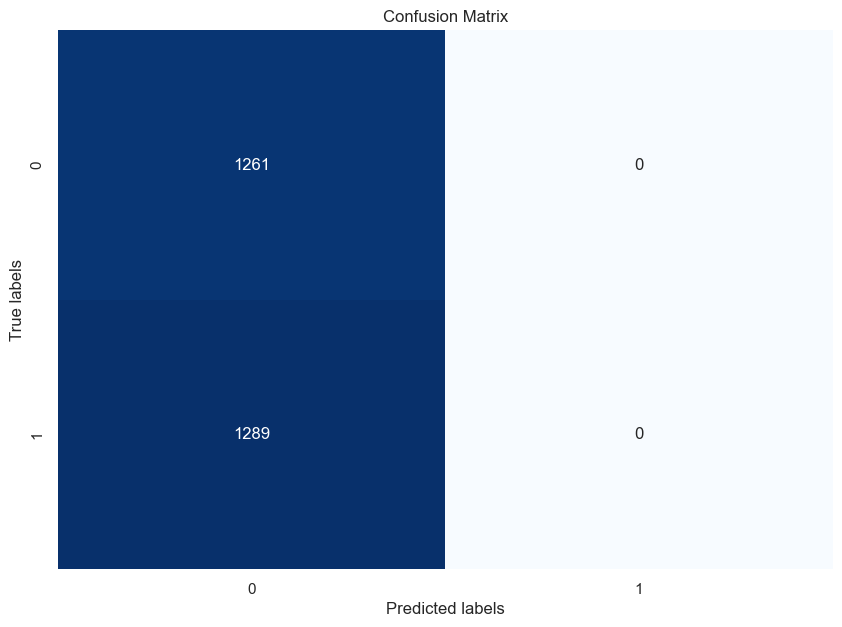

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [8]:
# Model Testing with over sampling
pipeline(df=clean2,
         hidden_layers=[(4, 'relu'), (2, 'relu'), (1, 'relu'), (1, 'sigmoid')], 
         EPOCHS=75,
         model=4,
         sampling='smote')

Undersampling performed slightly better but none of them addressed the issue with binary ratings of 1 not being predicted. Testing with fewer layers and neurons. 

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Epoch 1/10


/opt/anaconda3/envs/dev/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/127 ━━━━━━━━━━━━━━━━━━━━ 49s 394ms/step - accuracy: 0.5000 - loss: 0.7706
Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5
 35/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5105 - loss: 0.7374   
Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.we

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


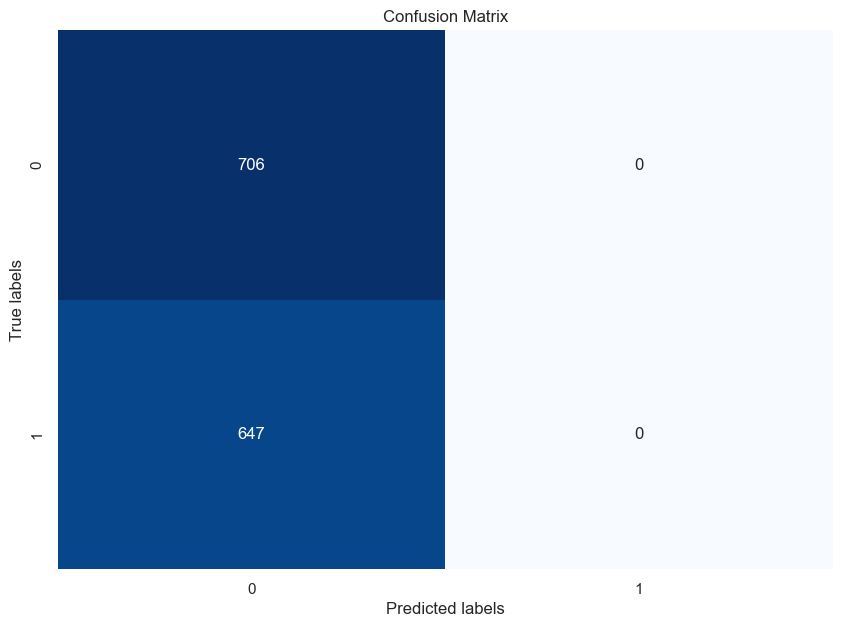

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [9]:
# Model Testing with over sampling
pipeline(df=clean2,
         hidden_layers=[(4, 'relu'), (1, 'sigmoid')], 
         EPOCHS=10,
         model=5,
         sampling='under')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Epoch 1/10


/opt/anaconda3/envs/dev/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/127 ━━━━━━━━━━━━━━━━━━━━ 52s 415ms/step - accuracy: 0.6562 - loss: 0.6678
Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5
 30/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5227 - loss: 0.6900   
Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.weights.h5

Epoch 1: saving model to ../models/deeplearning/checkpoints/model5weights.epoch_01.we

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


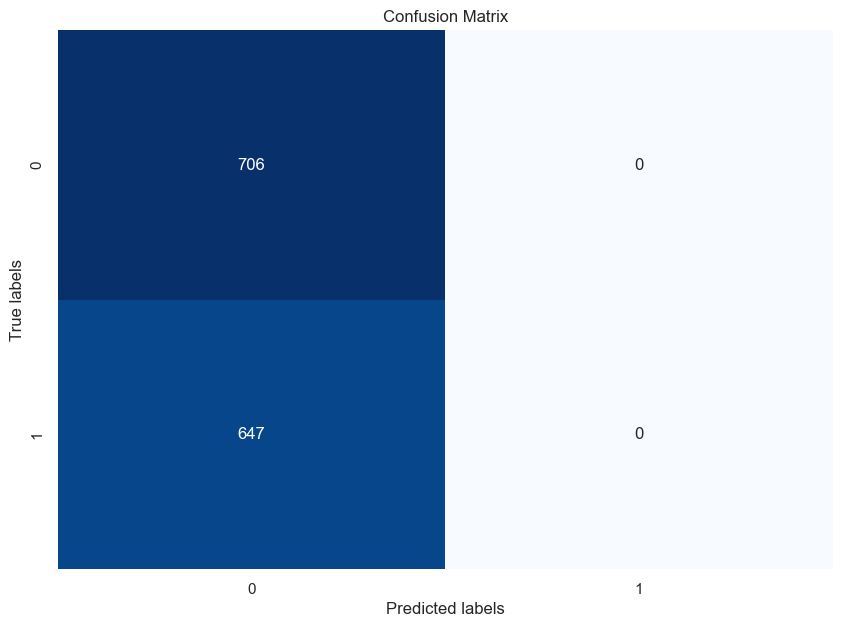

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [10]:
# Model Testing with over sampling
pipeline(df=dummies2,
         hidden_layers=[(4, 'relu'), (1, 'sigmoid')], 
         EPOCHS=10,
         model=5,
         sampling='under')

Despite experimenting with various features (reflected in the dataframes) and neural network designs, substantial performance gains have not been observed. Exploring different machine learning algorithms.

## Random Forest Machine Learning

In [11]:
def preprocess_data(df, sampling=None):
    X = df.drop(['Binary Rating'], axis=1)
    y = df['Binary Rating']
    
    if sampling == 'over':
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_resampled, y_resampled = oversample.fit_resample(X, y)
        print(y.describe())
    elif sampling == 'under':
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_resampled, y_resampled = undersample.fit_resample(X, y)
        print(y.describe())
    elif sampling == 'smote':
        smt = SMOTE()
        X_resampled, y_resampled = smt.fit_resample(X, y)
        print(y.describe())
    else:
        X_resampled, y_resampled = X, y
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42)
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, X.columns.tolist()

def train_random_forest(X_train_scaled, y_train, n_estimators=500, random_state=78):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf_model = rf_model.fit(X_train_scaled, y_train)
    return rf_model

def evaluate_random_forest(rf_model, X_test_scaled, y_test):
    predictions = rf_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    return cm

def plot_confusion_matrix(cm, model):
    sns.set()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.savefig(f'../img/models/random_forest/model{model}_confusion_matrix.png')
    plt.show()

def plot_feature_importances(rf_model, feature_names, model):
    importances = rf_model.feature_importances_
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importances_df = importances_df.sort_values(by='Importance', ascending=True)  
    plt.figure(figsize=(10, 6))
    plt.barh(importances_df['Feature'], importances_df['Importance'], color='lightgreen')
    plt.title(f"Model {model}'s Features Importances")
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.savefig(f'../img/models/random_forest/model{model}_importances_plot.png', bbox_inches='tight')
    plt.show()

def export_random_forest_tree(rf_model, X, model):
    single_tree = rf_model.estimators_[0]
    dot_data = export_graphviz(single_tree, out_file=None, 
                               feature_names=X.columns, 
                               class_names=['Class 0', 'Class 1'], 
                               filled=True, rounded=True, 
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.view(filename=f'../img/models/random_forest/model{model}_random_tree')
    dump(rf_model, f'../models/random_forest/model{model}.joblib')

def run_forest_pipeline(df, sampling=None, n_estimators=500, random_state=78, model=1):
    X_train_scaled, X_test_scaled, y_train, y_test, feature_names = preprocess_data(df, sampling)
    rf_model = train_random_forest(X_train_scaled, y_train, n_estimators, random_state)
    cm = evaluate_random_forest(rf_model, X_test_scaled, y_test)
    plot_confusion_matrix(cm, model)
    plot_feature_importances(rf_model, feature_names, model)
    export_random_forest_tree(rf_model, df.drop('Binary Rating', axis=1), model)

## Deep Forest Design Explanation

The `run_forest_pipeline` function orchestrates the training and evaluation of a random forest model. Here's how it works:

- `df`: Specifies the DataFrame containing the data for training and testing.
- `sampling`: Optional parameter to specify data sampling techniques ('over', 'under', 'smote'). Defaults to no sampling if not provided.
- `n_estimators`: Number of trees in the random forest. Defaults to 500 if not specified.
- `random_state`: Seed for random number generation. Defaults to 78 if not specified.
- `model`: An identifier for the model being trained. Defaults to 1 if not specified.

## Calling the Pipeline Function

To utilize the `run_forest_pipeline` function, follow this example:

```python
run_forest_pipeline(
    df=clean2, 
    sampling='none', 
    n_estimators=1000, 
    random_state=42, 
    model=1)


#### Testing the Models
First with no oversampling

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          581           69
Actual 1           62         1240
Accuracy Score: 0.9328893442622951
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       650
           1       0.95      0.95      0.95      1302

    accuracy                           0.93      1952
   macro avg       0.93      0.92      0.92      1952
weighted avg       0.93      0.93      0.93      1952



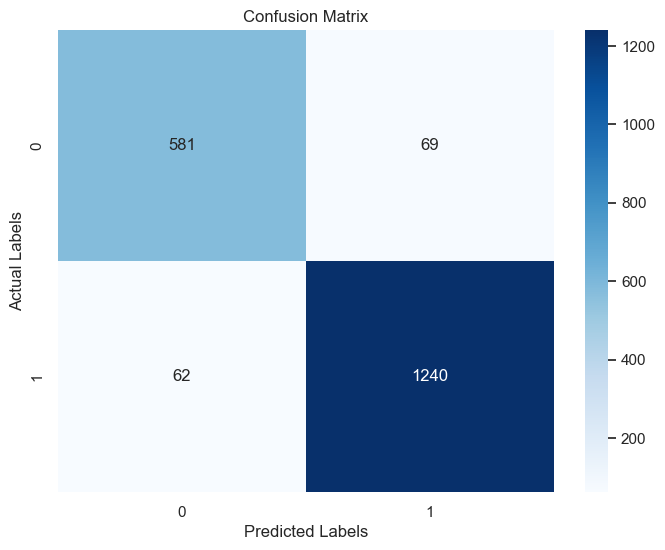

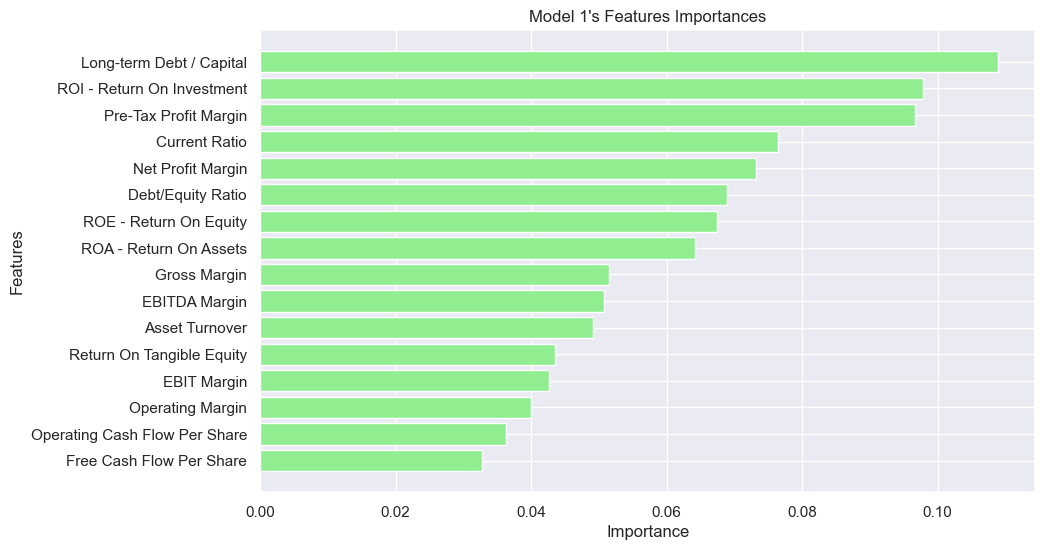

In [12]:
# No oversampling
run_forest_pipeline(
    df=clean2, 
    sampling='none', 
    n_estimators=1000, 
    random_state=42, 
    model=1)

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1186           75
Actual 1           89         1200
Accuracy Score: 0.9356862745098039
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1261
           1       0.94      0.93      0.94      1289

    accuracy                           0.94      2550
   macro avg       0.94      0.94      0.94      2550
weighted avg       0.94      0.94      0.94      2550



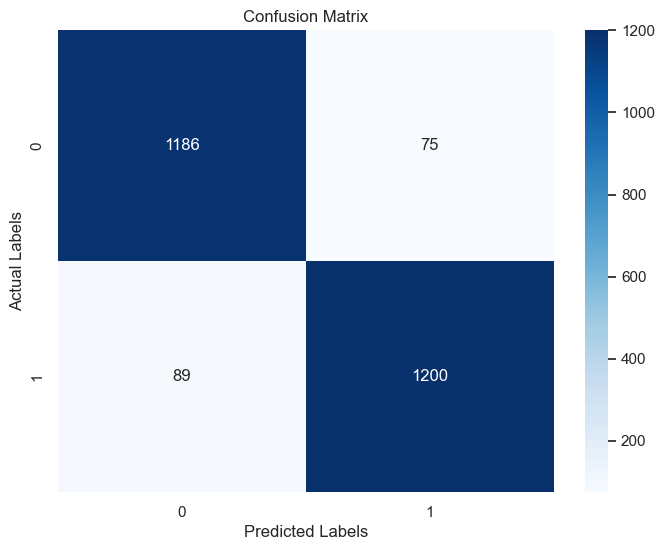

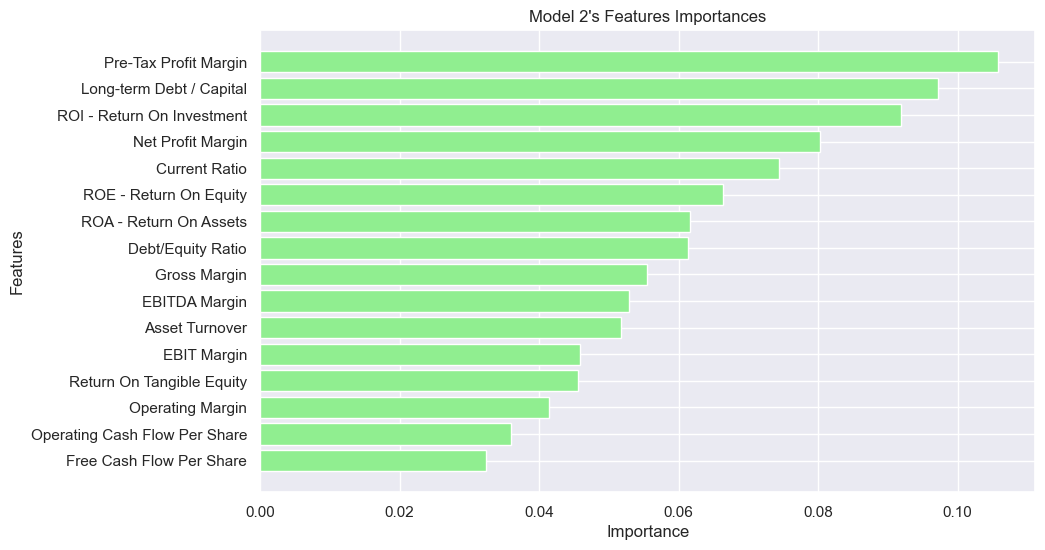

In [13]:
# Over Sampling
run_forest_pipeline(
    df=clean2, 
    sampling='over', 
    n_estimators=1000, 
    random_state=42, 
    model=2)

Test

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          645           61
Actual 1           64          583
Accuracy Score: 0.9076127124907613
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       706
           1       0.91      0.90      0.90       647

    accuracy                           0.91      1353
   macro avg       0.91      0.91      0.91      1353
weighted avg       0.91      0.91      0.91      1353



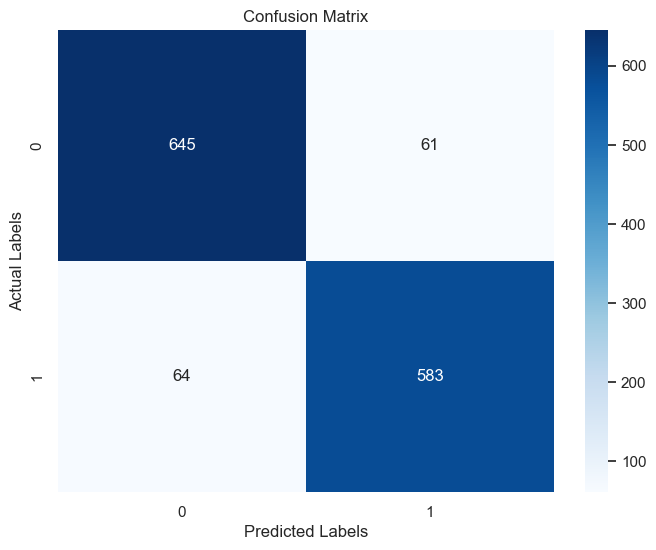

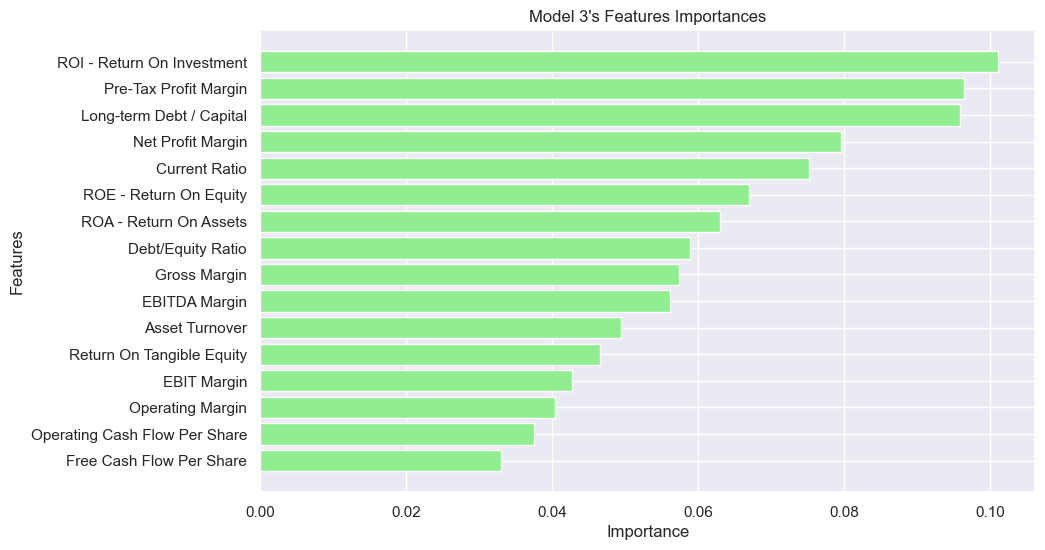

In [14]:
# Under sampling 
run_forest_pipeline(
    df=clean2, 
    sampling='under', 
    n_estimators=1000, 
    random_state=42, 
    model=3)

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1160          101
Actual 1           83         1206
Accuracy Score: 0.927843137254902
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1261
           1       0.92      0.94      0.93      1289

    accuracy                           0.93      2550
   macro avg       0.93      0.93      0.93      2550
weighted avg       0.93      0.93      0.93      2550



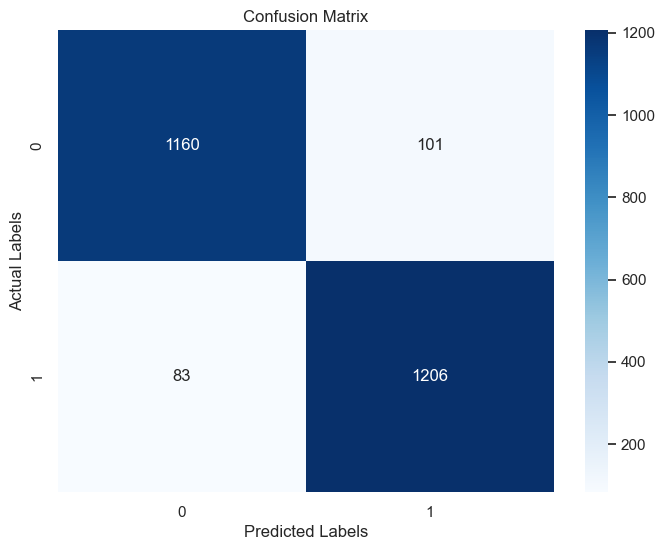

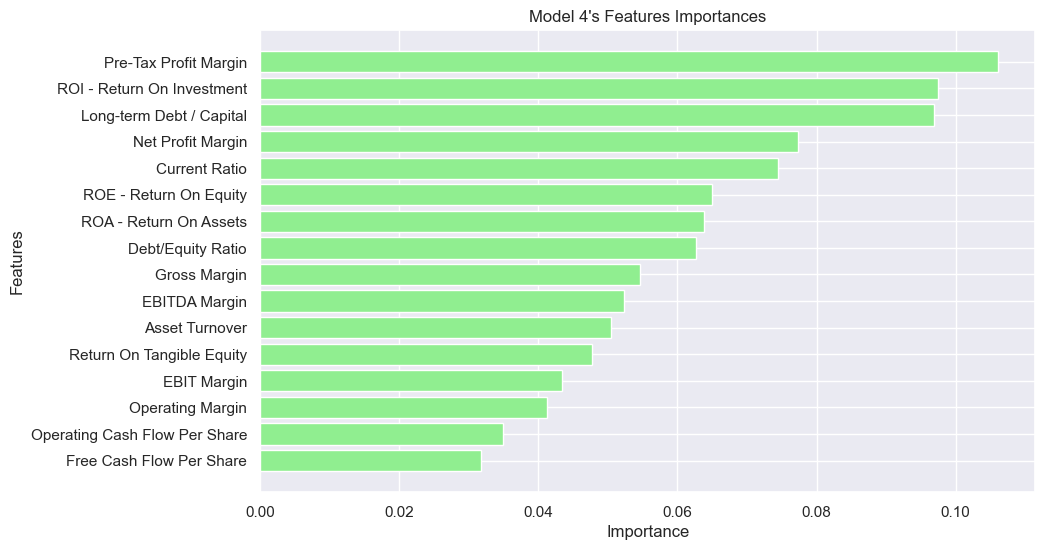

In [15]:
# SMOTE Oversampling 
run_forest_pipeline(
    df=clean2, 
    sampling='smote', 
    n_estimators=1000, 
    random_state=42, 
    model=4)

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1190           71
Actual 1           87         1202
Accuracy Score: 0.9380392156862745
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1261
           1       0.94      0.93      0.94      1289

    accuracy                           0.94      2550
   macro avg       0.94      0.94      0.94      2550
weighted avg       0.94      0.94      0.94      2550



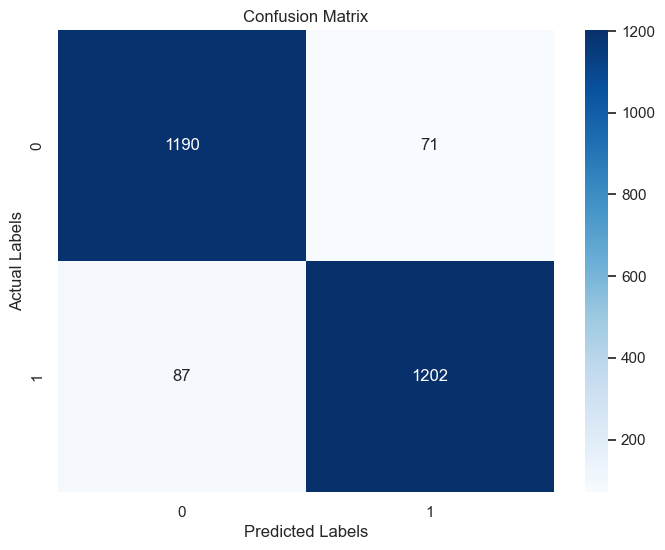

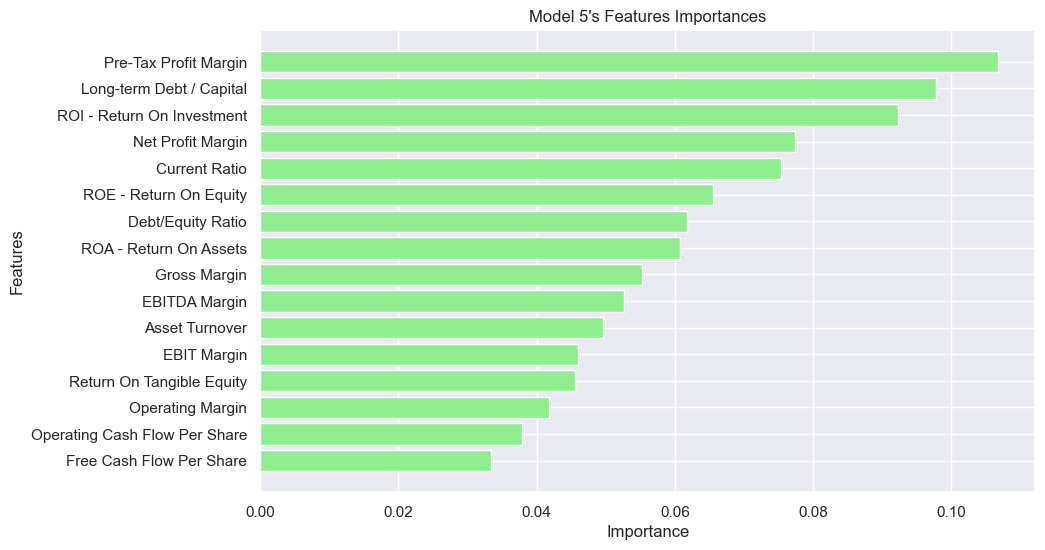

In [16]:
# Oversampling with get dummies 
run_forest_pipeline(
    df=dummies2, 
    sampling='over', 
    n_estimators=1000, 
    random_state=42, 
    model=5)

The random forest model excelled at predicting both classes (Junk and Investment Grades) despite the imbalanced data. It achieved a high accuracy of 94% using oversampling and dummy variable creation.

#### Model 5 is the winning model of the bunch. 

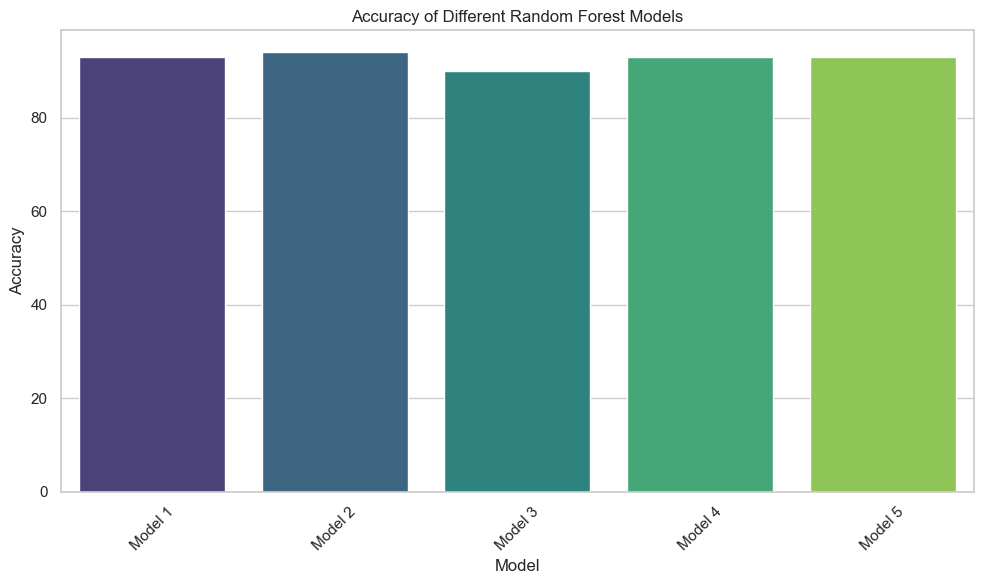

In [17]:
graph_values = {"Model 1": 93, "Model 2": 94, "Model 3": 90, "Model 4": 93, "Model 5": 93}

# Create a bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.barplot(x=list(graph_values.keys()), y=list(graph_values.values()), hue=list(graph_values.keys()), palette="viridis", dodge=False, legend=False)

# Adding labels
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Random Forest Models")

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## SVC  Machine Learning

In [18]:

def train_svc(X_train_scaled, y_train, kernel='rbf', C=1.0, gamma='scale', random_state=None):
    svc_model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state)
    svc_model.fit(X_train_scaled, y_train)
    return svc_model

def preprocess_data(df, sampling=None):
    X = df.drop(['Binary Rating'], axis=1)
    y = df['Binary Rating']
    
    if sampling == 'over':
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_resampled, y_resampled = oversample.fit_resample(X, y)
        print(y.describe())
    elif sampling == 'under':
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_resampled, y_resampled = undersample.fit_resample(X, y)
        print(y.describe())
    elif sampling == 'smote':
        smt = SMOTE()
        X_resampled, y_resampled = smt.fit_resample(X, y)
        print(y.describe())
    else:
        X_resampled, y_resampled = X, y
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42)
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, X.columns.tolist()

def evaluate_svc(svc_model, X_test_scaled, y_test):
    predictions = svc_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    return cm

def save_svc_model(svc_model, model_number):
    dump(svc_model, f'../models/svc/model{model_number}.joblib')

def svc_pipeline(data_frame, sampling=None, model_number=1, kernel='rbf', C=1.0, gamma='scale', random_state=None):
    X_train_scaled, X_test_scaled, y_train, y_test, X = preprocess_data(data_frame, sampling)
    svc_model = train_svc(X_train_scaled, y_train, kernel=kernel, C=C, gamma=gamma, random_state=random_state)
    cm = evaluate_svc(svc_model, X_test_scaled, y_test)
    plot_confusion_matrix(cm, model_number)
    plt.savefig(f'../img/models/svc/model{model_number}_confusion_matrix.png') 
    save_svc_model(svc_model, model_number)


## Support Vector Classifier (SVC) Design Explanation

The `svc_pipeline` function facilitates the training and evaluation of a Support Vector Classifier (SVC) model. Here's how it operates:

- `data_frame`: Specifies the DataFrame containing the data for training and testing.
- `sampling`: Optional parameter to specify data sampling techniques ('over', 'under', 'smote'). Defaults to no sampling if not provided.
- `model_number`: An identifier for the model being trained. Defaults to 1 if not specified.
- `kernel`: Specifies the kernel type to be used in the algorithm ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'). Defaults to 'rbf'.
- `C`: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. Defaults to 1.0.
- `gamma`: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. If 'scale', then it uses 1 / (n_features * X.var()). If 'auto', uses 1 / n_features. Defaults to 'scale'.
- `random_state`: Seed for random number generation. Defaults to None if not specified.

## Calling the Pipeline Function

To utilize the `svc_pipeline` function, follow this example:

```python
svc_pipeline(
    data_frame=clean_data, 
    sampling='over', 
    model_number=1, 
    kernel='rbf', 
    C=1.0, 
    gamma='scale', 
    random_state=42)


#### Testing the Models

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          361          289
Actual 1           84         1218
Accuracy Score: 0.8089139344262295
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.56      0.66       650
           1       0.81      0.94      0.87      1302

    accuracy                           0.81      1952
   macro avg       0.81      0.75      0.76      1952
weighted avg       0.81      0.81      0.80      1952



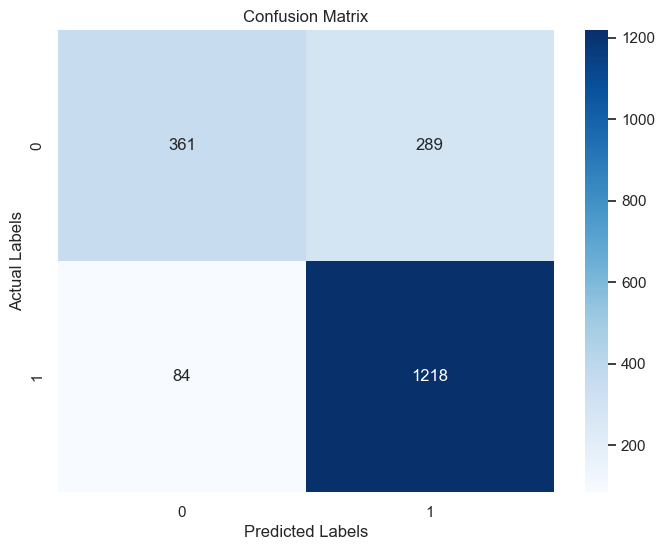

<Figure size 640x480 with 0 Axes>

In [19]:
# No sampling
svc_pipeline(
    data_frame=clean2, 
    sampling='none',
    model_number=1)

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          960          301
Actual 1          256         1033
Accuracy Score: 0.7815686274509804
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1261
           1       0.77      0.80      0.79      1289

    accuracy                           0.78      2550
   macro avg       0.78      0.78      0.78      2550
weighted avg       0.78      0.78      0.78      2550



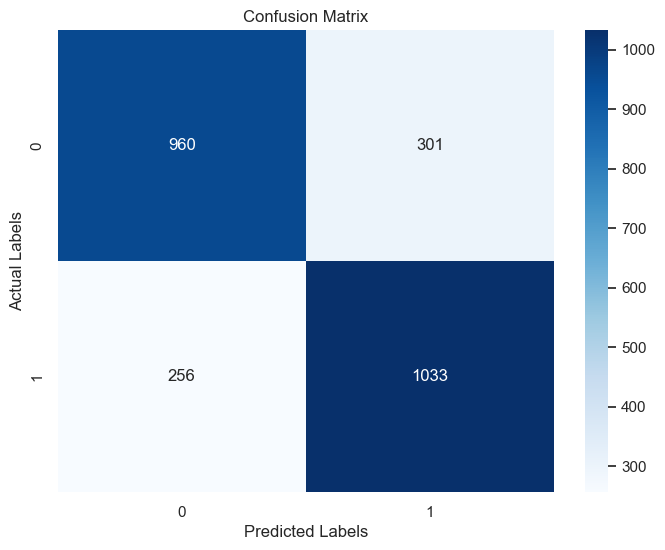

<Figure size 640x480 with 0 Axes>

In [20]:
# Oversampling 
svc_pipeline(
    data_frame=clean2, 
    sampling='over',
    model_number=2)

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          530          176
Actual 1          133          514
Accuracy Score: 0.7716186252771619
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       706
           1       0.74      0.79      0.77       647

    accuracy                           0.77      1353
   macro avg       0.77      0.77      0.77      1353
weighted avg       0.77      0.77      0.77      1353



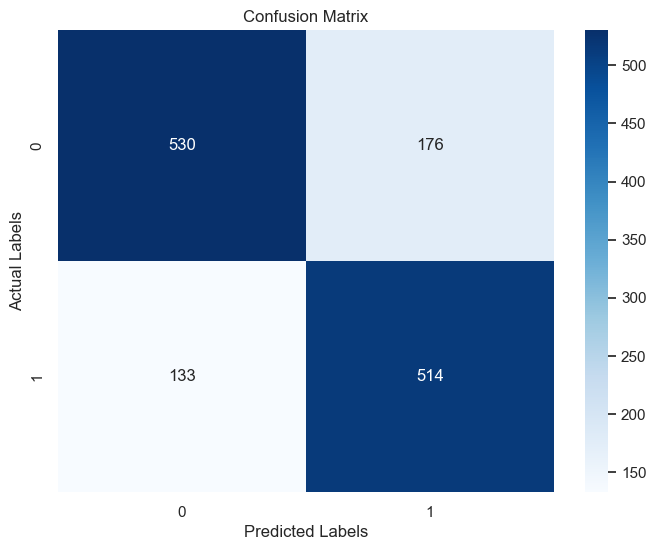

<Figure size 640x480 with 0 Axes>

In [21]:
# Undersampling 
svc_pipeline(
    data_frame=clean2, 
    sampling='under',
    model_number=3)

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          972          289
Actual 1          273         1016
Accuracy Score: 0.779607843137255
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1261
           1       0.78      0.79      0.78      1289

    accuracy                           0.78      2550
   macro avg       0.78      0.78      0.78      2550
weighted avg       0.78      0.78      0.78      2550



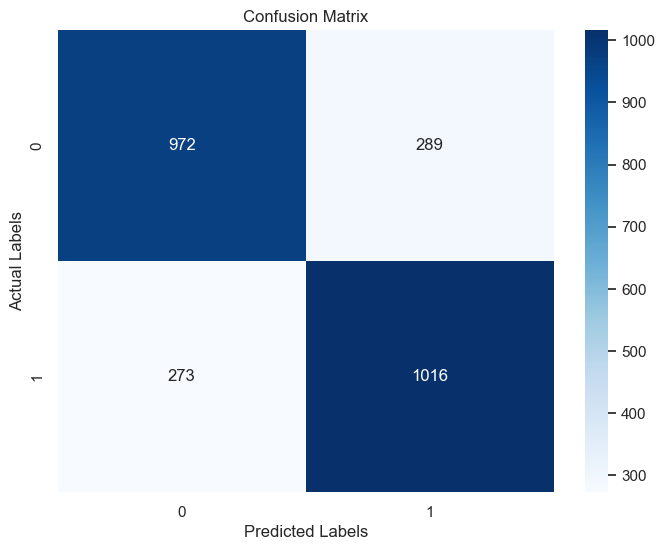

<Figure size 640x480 with 0 Axes>

In [22]:
# SMOTE oversampling  
svc_pipeline(
    data_frame=clean2, 
    sampling='smote',
    model_number=4)

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          361          289
Actual 1           84         1218
Accuracy Score: 0.8089139344262295
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.56      0.66       650
           1       0.81      0.94      0.87      1302

    accuracy                           0.81      1952
   macro avg       0.81      0.75      0.76      1952
weighted avg       0.81      0.81      0.80      1952



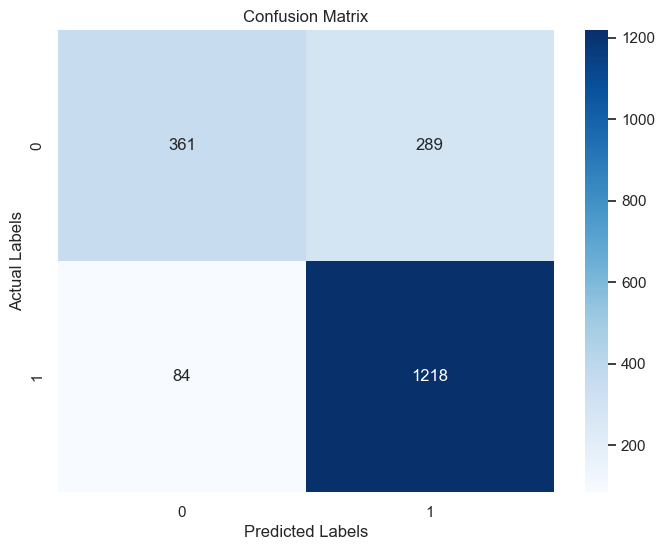

<Figure size 640x480 with 0 Axes>

In [23]:
# No sampling
svc_pipeline(
    data_frame=dummies2, 
    sampling='none',
    model_number=5)

SVC performed well but the Random Forest winning model was over 10% higher accuracy. Random Forest has better recall though both models show better performance than the neural network. 

## GBM (Gradient Boosting Machine) Machine Learning

In [24]:


def train_gbm(X_train_scaled, y_train, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
    gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    gbm_model.fit(X_train_scaled, y_train)
    return gbm_model

def evaluate_gbm(gbm_model, X_test_scaled, y_test):
    predictions = gbm_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    return cm

def save_gbm_model(gbm_model, model_number):
    dump(gbm_model, f'../models/gbm/model{model_number}.joblib')

def gbm_pipeline(data_frame, sampling=None, model_number=1, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
    X_train_scaled, X_test_scaled, y_train, y_test, X = preprocess_data(data_frame, sampling)
    gbm_model = train_gbm(X_train_scaled, y_train, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    cm = evaluate_gbm(gbm_model, X_test_scaled, y_test)
    plot_confusion_matrix(cm, model_number)
    
    # Explicitly display the plot before saving
    plt.show()
    
    # Now save the figure
    plt.savefig(f'../img/models/gbm/model{model_number}_confusion_matrix.png')  
    save_gbm_model(gbm_model, model_number)

## Gradient Boosting Machine (GBM) Design Explanation

The `gbm_pipeline` function orchestrates the training and evaluation of a Gradient Boosting Machine (GBM) model. Here's how it functions:

- `data_frame`: Specifies the DataFrame containing the data for training and testing.
- `sampling`: Optional parameter to specify data sampling techniques ('over', 'under', 'smote'). Defaults to no sampling if not provided.
- `model_number`: An identifier for the model being trained. Defaults to 1 if not specified.
- `n_estimators`: The number of boosting stages to be used. Defaults to 100 if not specified.
- `learning_rate`: Learning rate shrinks the contribution of each tree. Defaults to 0.1 if not specified.
- `max_depth`: Maximum depth of the individual regression estimators. Defaults to 3 if not specified.
- `random_state`: Seed for random number generation. Defaults to None if not specified.

## Calling the Pipeline Function

To utilize the `gbm_pipeline` function, follow this example:

```python
gbm_pipeline(
    data_frame=clean_data, 
    sampling='over', 
    model_number=1, 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=None)

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          457          193
Actual 1           91         1211
Accuracy Score: 0.8545081967213115
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       650
           1       0.86      0.93      0.90      1302

    accuracy                           0.85      1952
   macro avg       0.85      0.82      0.83      1952
weighted avg       0.85      0.85      0.85      1952



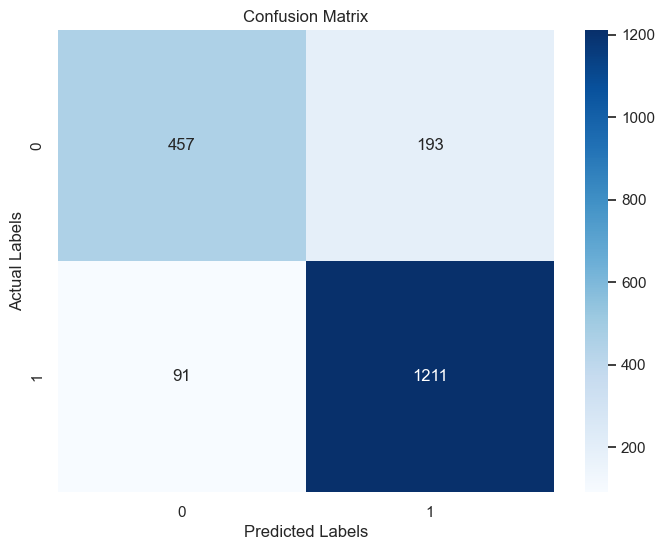

<Figure size 640x480 with 0 Axes>

In [25]:
# Model 1
gbm_pipeline(data_frame=clean2, 
             model_number=1,
             sampling='none')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1010          251
Actual 1          147         1142
Accuracy Score: 0.8439215686274509
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1261
           1       0.82      0.89      0.85      1289

    accuracy                           0.84      2550
   macro avg       0.85      0.84      0.84      2550
weighted avg       0.85      0.84      0.84      2550



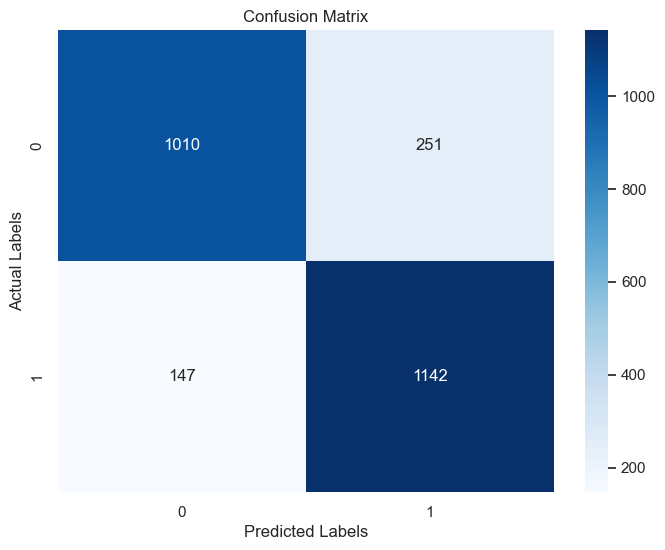

<Figure size 640x480 with 0 Axes>

In [26]:
# Model 2
gbm_pipeline(data_frame=clean2, 
             model_number=2,
             sampling='over')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          568          138
Actual 1           93          554
Accuracy Score: 0.8292682926829268
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       706
           1       0.80      0.86      0.83       647

    accuracy                           0.83      1353
   macro avg       0.83      0.83      0.83      1353
weighted avg       0.83      0.83      0.83      1353



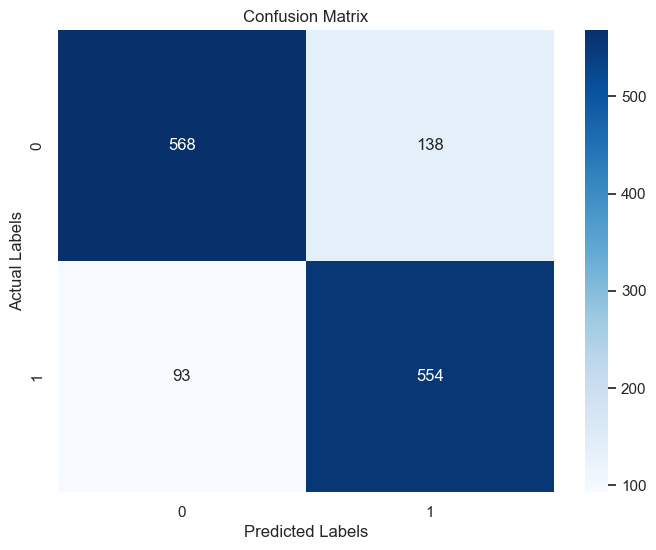

<Figure size 640x480 with 0 Axes>

In [27]:
# Model 3
gbm_pipeline(data_frame=clean2, 
             model_number=3,
             sampling='under')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1012          249
Actual 1          152         1137
Accuracy Score: 0.8427450980392157
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1261
           1       0.82      0.88      0.85      1289

    accuracy                           0.84      2550
   macro avg       0.84      0.84      0.84      2550
weighted avg       0.84      0.84      0.84      2550



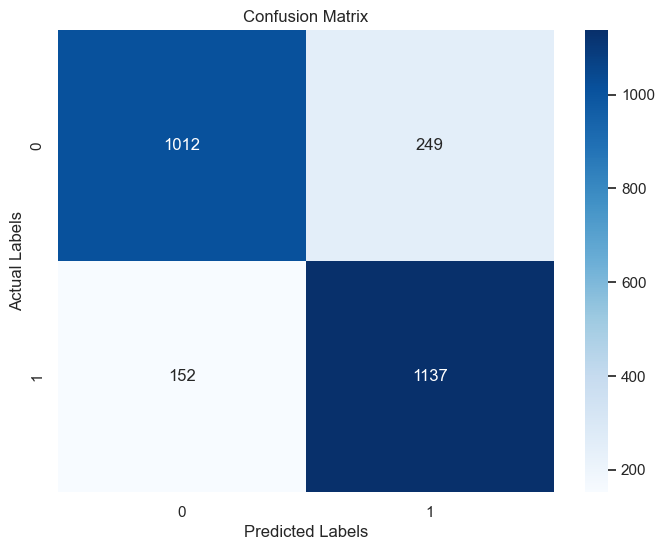

<Figure size 640x480 with 0 Axes>

In [28]:
gbm_pipeline(data_frame=clean2, 
             model_number=4,
             sampling='smote')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1027          234
Actual 1          159         1130
Accuracy Score: 0.8458823529411764
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1261
           1       0.83      0.88      0.85      1289

    accuracy                           0.85      2550
   macro avg       0.85      0.85      0.85      2550
weighted avg       0.85      0.85      0.85      2550



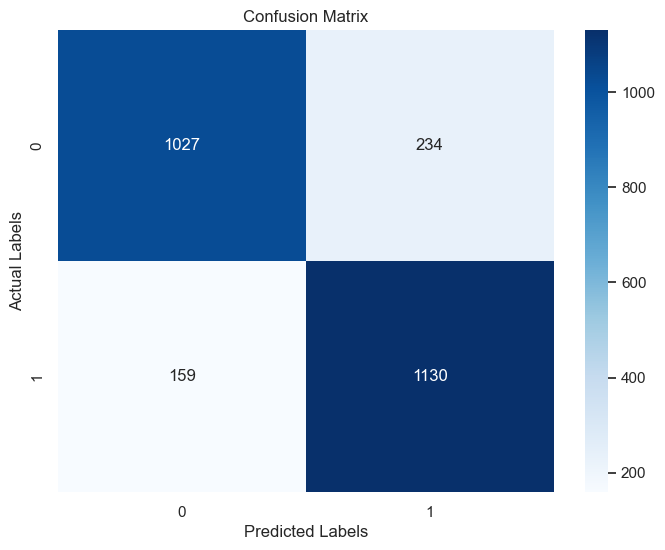

<Figure size 640x480 with 0 Axes>

In [29]:
gbm_pipeline(data_frame=dummies2, 
             model_number=5,
             sampling='over')

Blah

## XGBoost Machine Learning

To install use conda install -c conda-forge py-xgboost

In [30]:


def train_xgboost(X_train_scaled, y_train, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
    xgb_model = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    xgb_model.fit(X_train_scaled, y_train)
    return xgb_model

def evaluate_xgboost(xgb_model, X_test_scaled, y_test):
    predictions = xgb_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    return cm

def save_xgboost_model(xgb_model, model_number):
    dump(xgb_model, f'../models/xgboost/model{model_number}.joblib')


def plot_confusion_matrix(cm, model_number):
    sns.set()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'])
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')
    ax.set_yticklabels(['Actual 0', 'Actual 1'], rotation=0)     
    plt.savefig(f'../img/models/xgboost/model{model_number}_confusion_matrix.png')
    plt.show()

def xgboost_pipeline(data_frame, sampling, model_number, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
    X_train_scaled, X_test_scaled, y_train, y_test, X = preprocess_data(data_frame, sampling)
    xgb_model = train_xgboost(X_train_scaled, y_train, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    cm = evaluate_xgboost(xgb_model, X_test_scaled, y_test)
    plot_confusion_matrix(cm, model_number)
    plt.savefig(f'../img/models/xgboost/model{model_number}_confusion_matrix.png') 
    save_xgboost_model(xgb_model, model_number)



## XGBoost Model Design Explanation

The `xgboost_pipeline` function serves as the orchestrator for training and evaluating an XGBoost model. Here's a breakdown of its functionalities:

- `data_frame`: Indicates the DataFrame containing the data for both training and testing.
- `sampling`: An optional parameter allowing the specification of data sampling techniques ('over', 'under', 'smote'). If not provided, no sampling is performed.
- `model_number`: An identifier for the model being trained. Defaults to 1 if not explicitly specified.
- `n_estimators`: Defines the number of boosting stages to be utilized. Defaults to 100 if not explicitly set.
- `learning_rate`: Sets the learning rate, which controls the contribution of each tree. Defaults to 0.1 if not specified.
- `max_depth`: Specifies the maximum depth of the individual regression estimators. Defaults to 3 if not provided.
- `random_state`: Seed for random number generation. If not specified, defaults to None.

## Utilizing the Pipeline Function

To make use of the `xgboost_pipeline` function, follow the example below:

```python
xgboost_pipeline(
    data_frame=clean_data, 
    sampling='over', 
    model_number=1, 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=None)


#### Testing the Models

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          450          200
Actual 1           91         1211
Accuracy Score: 0.850922131147541
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.76       650
           1       0.86      0.93      0.89      1302

    accuracy                           0.85      1952
   macro avg       0.85      0.81      0.82      1952
weighted avg       0.85      0.85      0.85      1952



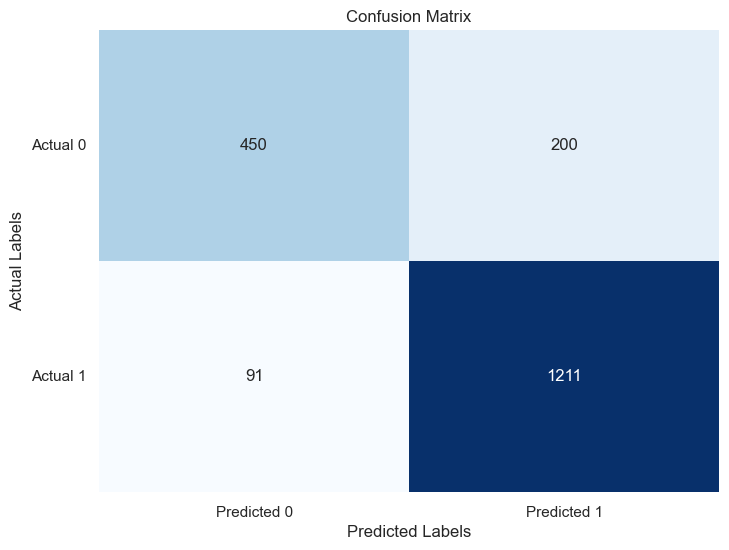

<Figure size 640x480 with 0 Axes>

In [31]:
# Model 1
xgboost_pipeline(
    data_frame=clean2, 
    model_number=1, 
    sampling='none')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1023          238
Actual 1          161         1128
Accuracy Score: 0.8435294117647059
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1261
           1       0.83      0.88      0.85      1289

    accuracy                           0.84      2550
   macro avg       0.84      0.84      0.84      2550
weighted avg       0.84      0.84      0.84      2550



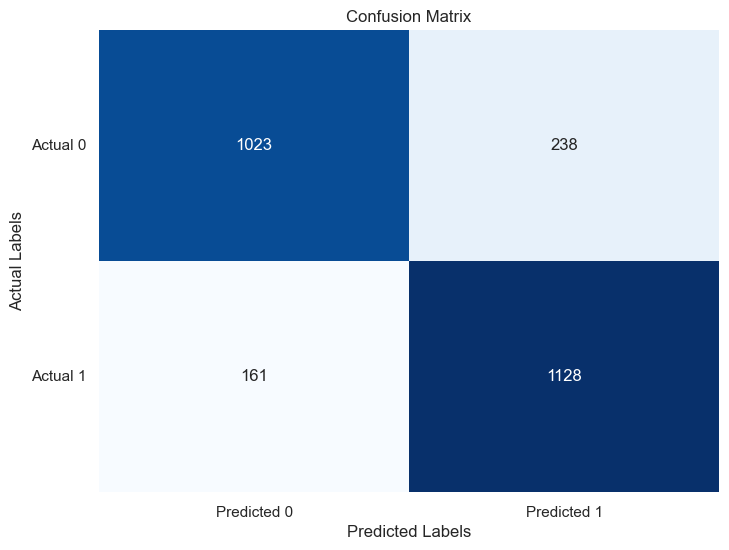

<Figure size 640x480 with 0 Axes>

In [32]:
# Model 2
xgboost_pipeline(
    data_frame=clean2, 
    model_number=2, 
    sampling='over')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          562          144
Actual 1           92          555
Accuracy Score: 0.8255728011825573
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       706
           1       0.79      0.86      0.82       647

    accuracy                           0.83      1353
   macro avg       0.83      0.83      0.83      1353
weighted avg       0.83      0.83      0.83      1353



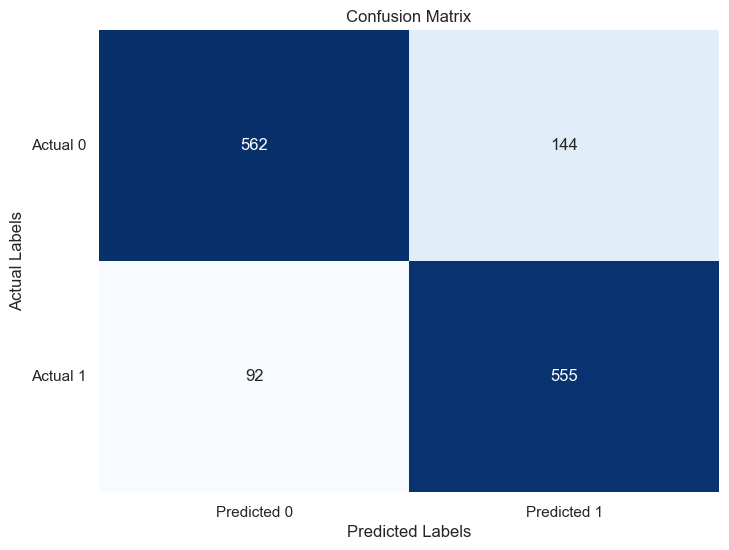

<Figure size 640x480 with 0 Axes>

In [33]:
# Model 3
xgboost_pipeline(
    data_frame=clean2, 
    model_number=3, 
    sampling='under')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1009          252
Actual 1          156         1133
Accuracy Score: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1261
           1       0.82      0.88      0.85      1289

    accuracy                           0.84      2550
   macro avg       0.84      0.84      0.84      2550
weighted avg       0.84      0.84      0.84      2550



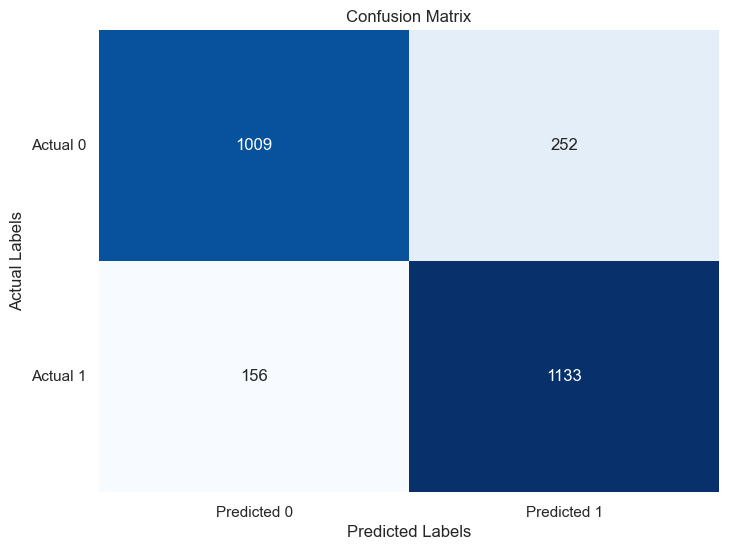

<Figure size 640x480 with 0 Axes>

In [34]:
xgboost_pipeline(
    data_frame=clean2, 
    model_number=4, 
    sampling='smote')

count    7805.000000
mean        0.653299
std         0.475950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Binary Rating, dtype: float64
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1017          244
Actual 1          151         1138
Accuracy Score: 0.8450980392156863
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1261
           1       0.82      0.88      0.85      1289

    accuracy                           0.85      2550
   macro avg       0.85      0.84      0.84      2550
weighted avg       0.85      0.85      0.84      2550



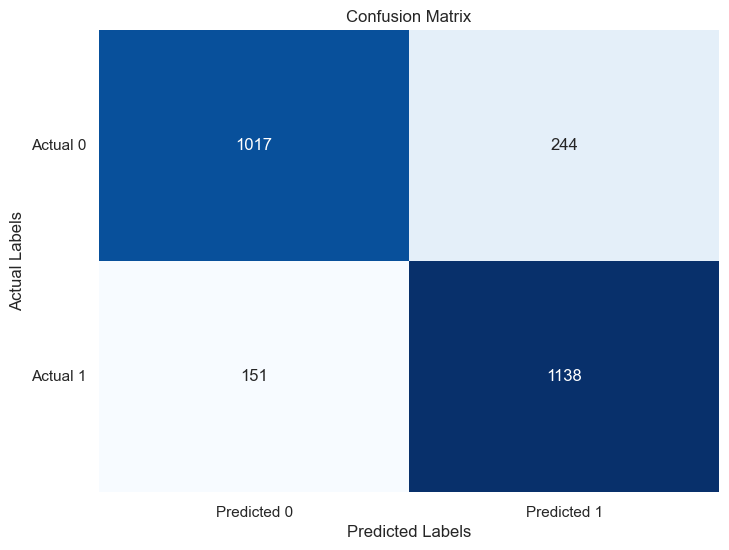

<Figure size 640x480 with 0 Axes>

In [35]:
xgboost_pipeline(
    data_frame=dummies2, 
    model_number=5, 
    sampling='smote')

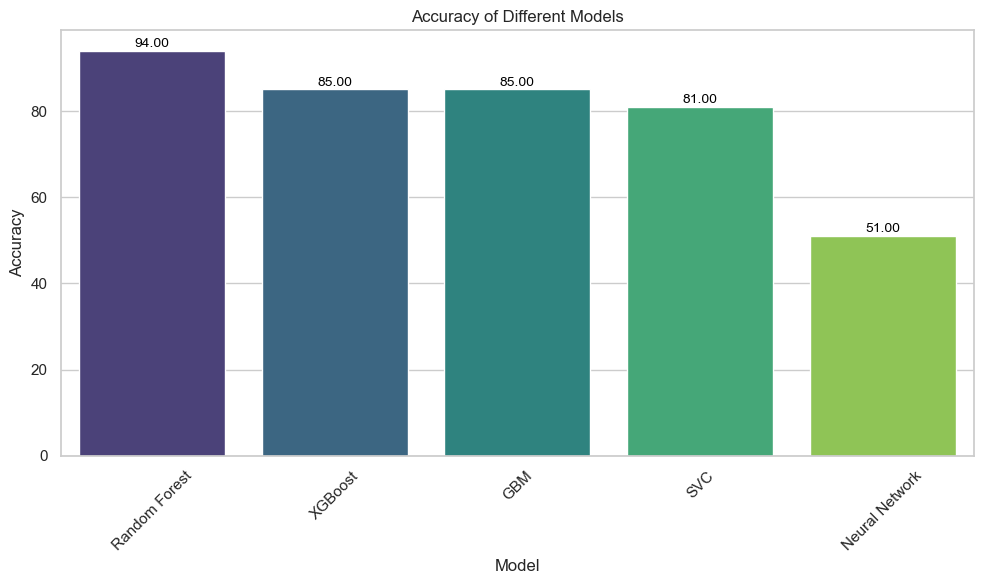

In [41]:
graph_values = {"Random Forest": 94, "XGBoost": 85, "GBM": 85, "SVC": 81, "Neural Network": 51}

# Create a bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
ax = sns.barplot(x=list(graph_values.keys()), y=list(graph_values.values()), hue=list(graph_values.keys()), palette="viridis", dodge=False, legend=False)

# Adding labels
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Models")

# Adding values on top of bars
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

In this study, various machine learning models were assessed for their effectiveness in a classification task, including Random Forest, XGBoost, Gradient Boosting Machine (GBM), and Support Vector Classifier (SVC). All models exhibited strong performance, yet the Random Forest classifier emerged with the highest overall accuracy.

Particularly noteworthy was the performance of model #5 within the Random Forest framework. By utilizing feature encoding with `get_dummies` and data oversampling techniques, this model yielded the most promising results. These findings suggest that employing Random Forest in conjunction with these preprocessing methods might offer the most optimal solution for this dataset and classification challenge.
